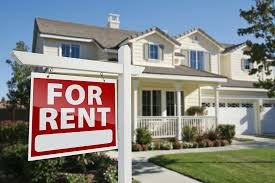

Hey Guys! In this notebook, we will be doing detailed analyis of factors contributing towards house rent in brazil. Analysis is done on publicly hosted dataset on [kaggle](https://www.kaggle.com/rubenssjr/brasilian-houses-to-rent/). We will be doing descriptive, univariate, multi variate analysis. Also, will try to learn important/contributing factors towards house rent by doing PCA analyisis. En the end we will apply some regressoin techniques and evaluate their performance.

Data Analysis is all about finding some intersting insights in the data and we can find more insight by asking more questions and here I'm going to find some interesting insights in the data by asking the following questions:
* How total(price of house) is distributed?
* How rent amount is distributed?
* Significance of No of Rooms with the Rent
* What about pets?
* City and the rooms
* Does the city has to do any thing with rent?
* Does the people are looking for more bathrooms? (Silly Right)
* Does furnishing impact in the rent?
* Whats the relationship between parking spaces and the total rent?
* What about Fire Insurance?
* What about the impact of property tax in the rent?
Finally we will create a machine learning model to perform predictive analysis. I can assure that this is gonna be very interesting stuff...
Let's Start----->

# Import Libraries

In [ ]:
!pip install plotly==4.7.1 cufflinks
import plotly
print(plotly.__version__)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.impute import SimpleImputer
# Basic packages
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, gc
from scipy import stats; from scipy.stats import zscore, norm, randint
import matplotlib.style as style; style.use('fivethirtyeight')
# Models
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, learning_curve

# Display settings
pd.options.display.max_rows = 400
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format

random_state = 42
np.random.seed(random_state)

# Suppress warnings
import warnings; warnings.filterwarnings('ignore')

# Import Data and Overview

In [ ]:
data = pd.read_csv('/kaggle/input/brasilian-houses-to-rent/houses_to_rent_v2.csv')
data.head()

In [ ]:
data.columns

In [ ]:
data.info()

In [ ]:
columns = data.select_dtypes(exclude=['int64', 'float64']).columns.tolist()
for cols in columns:
    print(f'Unique values for {cols} is \n{data[cols].unique()}\n')

In [ ]:
# replacing categorical values
replace_struc = {'acept': 0, 'not acept': 1}
data['animal'] = data['animal'].map(replace_struc)
replace_struc = {'furnished': 0, 'not furnished': 1}
data['furniture'] = data['furniture'].map(replace_struc)
del replace_struc

In [ ]:
data.shape

# Five point summary of numerical attributes

In [ ]:
data.describe().T

# Checking missing values

In [ ]:
# Check missing values in the dataframe
data.isnull().sum()

# Univariate Analysis

In [ ]:
# Functions that will help us with EDA plot
def odp_plots(df, col):
    f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 7.2))
    
    # Boxplot to check outliers
    sns.boxplot(x = col, data = df, ax = ax1, orient = 'v', color = 'darkslategrey')
    
    # Distribution plot with outliers
    sns.distplot(df[col], ax = ax2, color = 'teal', fit = norm).set_title(f'{col} with outliers')
    
    # Removing outliers, but in a new dataframe
    upperbound, lowerbound = np.percentile(df[col], [1, 99])
    y = pd.DataFrame(np.clip(df[col], upperbound, lowerbound))
    
    # Distribution plot without outliers
    sns.distplot(y[col], ax = ax3, color = 'tab:orange', fit = norm).set_title(f'{col} without outliers')
    
    kwargs = {'fontsize':14, 'color':'black'}
    ax1.set_title(col + ' Boxplot Analysis', **kwargs)
    ax1.set_xlabel('Box', **kwargs)
    ax1.set_ylabel(col + ' Values', **kwargs)

    return plt.show()

In [ ]:
# Outlier, distribution for columns with outliers
boxplotcolumns = ['area', 'hoa (R$)', 'rent amount (R$)', 'property tax (R$)',
                  'fire insurance (R$)','total (R$)']
for cols in boxplotcolumns:
    Q3 = data[cols].quantile(0.75)
    Q1 = data[cols].quantile(0.25)
    IQR = Q3 - Q1

    print(f'{cols.capitalize()} column', '--'*40)
    count = len(data.loc[(data[cols] < (Q1 - 1.5 * IQR)) | (data[cols] > (Q3 + 1.5 * IQR))])
    print(f'no of records with outliers values: {count}')
    
    display(data.loc[(data[cols] < (Q1 - 1.5 * IQR)) | (data[cols] > (Q3 + 1.5 * IQR))].head())
    print(f'EDA for {cols.capitalize()} column', '--'*40)
    odp_plots(data, cols)

del cols, IQR, boxplotcolumns

#### Observation: There are too much of outliers and the difference can be seen in distplots with/without outliers. Removing outliers gives much smoothen curves. Mostly, the attributes are right skewed.


# Multivariate Analysis

### Percentage Weightage of rent in all the cities

In [ ]:
data.info()

In [ ]:
city1 = data.loc[:,['city','rent amount (R$)']]
city1['data'] = city1.groupby('city')['rent amount (R$)'].transform('sum')
fig = px.pie(city1, names = 'city', values='data', template='seaborn')
fig.update_traces(rotation=90,pull=[0.2,0.03,0.1,0.03,0.1], showlegend=True)
fig.show()

<p> Observation: Maximum no of rented house availability is in Sau Paulo</p>

# How all categorical attributes are mapped on Area vs Rent scatter plot?

In [ ]:
area_df = data[data['area'] < 2000 ]
area_df = area_df[area_df['city']=="Rio de Janeiro"]
fig = px.scatter(area_df, x="rent amount (R$)", y="area", color="furniture",
           hover_name="furniture", log_x=True, size_max=30, marginal_y="violin",
           marginal_x="box", trendline="ols")
fig.show()

<p>Obseravtion : Unfurnished rented houses can have lower rent and area compared to furnished houses.</p>

In [ ]:
fig = px.scatter(area_df, x="rent amount (R$)", y="area", color="animal",
           hover_name="animal", log_x=True, size_max=40, marginal_y="violin",
           marginal_x="box", trendline="ols")
fig.show()

<p>Obseravtion : Animal acceptance/non acceptance does not affect house rent.</p>

In [ ]:
fig = px.scatter(area_df, x="rent amount (R$)", y="area", color="parking spaces",
           hover_name="parking spaces", size= "parking spaces", log_x=True, size_max=30)
fig.show()

<p>Obseravtion : Higher no of parking spaces yields in higher area(obvious) and higher house rent.</p>

In [ ]:
fig = px.scatter(area_df, x="rent amount (R$)", y="area", color="bathroom",
           hover_name="bathroom", size= "bathroom", log_x=True, size_max=30)
fig.show()

<p>Obseravtion : Higher no of bathrooms spaces yields higher house rent.</p>

In [ ]:
fig = px.scatter(area_df, x="rent amount (R$)", y="area", color="rooms",
           hover_name='rooms', size= "rooms", log_x=True, size_max=30)
fig.show()

<p>Obseravtion : Higher no of rooms yields higher house rent.</p>

# Distribution of Area vs Rent

In [ ]:
 sns.lmplot(x="rent amount (R$)", y="area", data=area_df)

In [ ]:
# Correlation matrix for all variables
def correlation_matrix(df, threshold = 0.8):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype = np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize = (15, 7.2))
    cmap = sns.diverging_palette(220, 10, as_cmap = True)
    sns.heatmap(corr, mask = mask, cmap = cmap, square = True, linewidths = .5, cbar_kws = {"shrink": .5})#, annot = True)
    ax.set_title('Correlation Matrix of Data')

    # Filter for correlation value greater than threshold
    sort = corr.abs().unstack()
    sort = sort.sort_values(kind = "quicksort", ascending = False)
    display(sort[(sort > threshold) & (sort < 1)])
correlation_matrix(data, threshold = 0.7)

#### Observation: High correlation between total rent,fire insurance, rent amount, hoa is visible. 

## Absolute correlation of independent variables with the target variable

In [ ]:
data= data.select_dtypes(include=['int64', 'float64'])
absCorrwithDep = []
allVars = data.drop('rent amount (R$)', axis = 1).columns

for var in allVars:
    absCorrwithDep.append(abs(data['rent amount (R$)'].corr(data[var])))

display(pd.DataFrame([allVars, absCorrwithDep], index = ['Variable', 'Correlation']).T.\
        sort_values('Correlation', ascending = False))

#### Dropping hoa due to very low correlation with target variable.

In [ ]:
data = data.drop('hoa (R$)', axis = 1)

# PCA Analysis

In [ ]:
data.head()

In [ ]:
target = data['rent amount (R$)']
#features = data.drop(['rent amount (R$)'])
# Splitting the data into training and test set in the ratio of 75:25 respectively
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.25, 
                                                    random_state = random_state, shuffle = False)

In [ ]:
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)
y_train = y_train.values
y_test = y_test.values

display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [ ]:
# Covariance matrix
cov_matrix = np.cov(X_train.T)
print('Covariance Matrix \n%s', cov_matrix)

In [ ]:
# Eigen values and vector
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)
print('Eigen Vectors \n%s', eig_vecs)
print('\n Eigen Values \n%s', eig_vals)

In [ ]:
# Cumulative variance explained
tot = sum(eig_vals)
var_exp = [(i /tot) * 100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

print('Cumulative Variance Explained', cum_var_exp)

In [ ]:
plt.figure(figsize = (15 , 7.2))
plt.plot(var_exp)

In [ ]:
# Ploting 
plt.figure(figsize = (15 , 7.2))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where = 'mid', label = 'Cumulative explained variance')
plt.axhline(y = 95, color = 'r', linestyle = '--')
plt.axvline(x = 8, color = 'r', linestyle = '--')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

<p>Visually we can observe that their is steep drop in variance explained with increase in number of PC's. We will proceed with 8 components here which covers more than 95% of variance.
</p>

In [ ]:
from sklearn.decomposition import PCA
# Reducing the dimensions from 10 to 8
pca = PCA(n_components = 8, random_state = random_state)
pca.fit(X_train)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.fit_transform(X_test)
display(X_train_reduced.shape, X_test_reduced.shape)

In [ ]:
pca.components_

In [ ]:
# Pairplot after dimension reduction
sns.pairplot(pd.DataFrame(X_train_reduced), diag_kind = 'kde')

In [ ]:
# Creating a dimension reduced with features and target
df_train = pd.DataFrame(X_train_reduced).join(pd.DataFrame(y_train, columns = ['rent amount (R$)']), how = 'left', sort = False)
df_test = pd.DataFrame(X_test_reduced).join(pd.DataFrame(y_test, columns = ['rent amount (R$)']), how = 'left', sort = False)
df_train.shape, df_test.shape

# Statistical Description of the data on which we are going to do perdictive analysis

In [ ]:
y = df_train['rent amount (R$)']
x = df_train.drop(['rent amount (R$)'],axis =1)

In [ ]:
y.describe()

In [ ]:
x.info()

In [ ]:
from sklearn.model_selection import train_test_split as tts
X_train,X_test,y_train,y_test = tts(x,y,test_size =0.3)

In [ ]:
acc=[]

# Predictive analysis of Rent using
* Decision Tree Regression
* Random Forest Regression
* Linear Regression
* SVM Regression
* K Nearest Neighbour Regression
* Lasso Regression
* Ridge Regression

# Decision Tree Regression

In [ ]:
from sklearn.tree import DecisionTreeRegressor as regr
model =regr()
model.fit(X_train,y_train)
from sklearn.metrics import r2_score
print(r2_score(y_test,model.predict(X_test)))
acc.append(['DTR',r2_score(y_test,model.predict(X_test))])

# Visualising the Decision Tree

# Random Forest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor as regr
model =regr()
model.fit(X_train,y_train)
print(r2_score(y_test,model.predict(X_test)))
acc.append(['RFN',r2_score(y_test,model.predict(X_test))])

# Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression as regr
model =regr()
model.fit(X_train,y_train)
print(r2_score(y_test,model.predict(X_test)))
acc.append(['LIR',r2_score(y_test,model.predict(X_test))])

# SVM Regression

In [ ]:
from sklearn.svm import SVR as regr
model =regr()
model.fit(X_train,y_train)
print(r2_score(y_test,model.predict(X_test)))
acc.append(['SVM',r2_score(y_test,model.predict(X_test))])

# K Nearest Neighbour Regression

In [ ]:
from sklearn.neighbors import KNeighborsRegressor as regr
model =regr()
model.fit(X_train,y_train)
print(r2_score(y_test,model.predict(X_test)))
acc.append(['KNNR',r2_score(y_test,model.predict(X_test))])

# Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso as regr
model =regr()
model.fit(X_train,y_train)
print(r2_score(y_test,model.predict(X_test)))
acc.append(['LaR',r2_score(y_test,model.predict(X_test))])

# Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge as regr
model =regr()
model.fit(X_train,y_train)
print(r2_score(y_test,model.predict(X_test)))
acc.append(['RiR',r2_score(y_test,model.predict(X_test))])

# Different Algorithms and their performance

In [ ]:
acc.sort(key = lambda y:y[1],reverse =True)

In [ ]:
acc

# As the Lasso Regressor tops the list we will use it as our final model!!!!

In [ ]:
from sklearn.ensemble import RandomForestRegressor as regr
model =regr()
model.fit(X_train,y_train)

In [ ]:
ax1 = sns.distplot(y_test,hist=False,kde =True,color ="r",label ="Actual Value")
sns.distplot(model.predict(X_test),color ="b",hist = False,kde =True, label = "Preicted Value",ax =ax1)

**The overlapping of two curves tells about the higher accuracy of our model (99%)**